# Case Study: Air Quality

This notebook analyses the air-quality dataset collected by the [Castile and
León
initiative](https://datosabiertos.jcyl.es/web/es/datos-abiertos-castilla-leon.html)
in Spain, previously analysed by [Alcaide & Aerts
(2020)](https://ieeexplore.ieee.org/document/9096616/). They found several
interesting patterns that we attempt to re-discover using UMAP filters. The goal
of this notebook is to demonstrate using the filtering functions to inspect
different perspectives.

## Setup

Loading libraries:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Data
import re
import time
import warnings
import numpy as np
import numba as nb
import pandas as pd
from datetime import date
from anndata import AnnData
from anndata._core.anndata import ImplicitModificationWarning
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import make_classification, make_blobs
from scipy.spatial.distance import cdist

# UMAP
from umap import UMAP
from umap.umap_ import reset_local_connectivity as reset_connectivity
import lensed_umap as lu
from fast_hdbscan import HDBSCAN

# Plotting
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import connect_edges
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpecFromSubplotSpec
from lib.plotting import *

configure_matplotlib()
# Disable specific warnings to clean up the output
warnings.filterwarnings("ignore", lineno=151, module=r"sklearn.*")
warnings.filterwarnings("ignore", category=nb.core.errors.NumbaWarning)
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)

Call numba-compiled code paths so timing can be measured without the compile step later on.

In [ ]:
X, _ = make_classification()
lens, _ = make_blobs()
projector = UMAP(force_approximation_algorithm=True).fit(X)
_ = lu.apply_lens(projector, lens[:, 0])
_ = lu.apply_mask(projector, UMAP().fit(lens))
_ = lu.apply_local_mask(projector, lens)
_ = HDBSCAN().fit(X)
del projector, X, lens, _

## The data

The data describes seven chemical's concentration in the air (CO (mg/m3), NO
(ug/m3), NO2 (ug/m3), SO2 (ug/m3), O3 (ug/m3), PM10 (ug/m3), PM25 (ug/m3)).
Measurements are taken daily at several locations, with more locations being
added over time. The measurements started in 1997 and ran till the end of 2020.
We load the data from a `.csv` file and construct an `AnnData` object splitting
features from metadata.

In [3]:
seasons = ["winter", "spring", "summer", "autumn"]
periods = ["1997-2002", "2003-2008", "2009-2014", "2015-2020"]
year_ticks = np.asarray([int(p.split("-")[0]) for p in periods])

In [4]:
def classify_year(year):
    """Returns the period for a given year."""
    idx = np.where(year < year_ticks)[0]
    idx = idx[0] if 0 < len(idx) else 0
    return periods[idx - 1]


def load_data():
    raw = (
        pd.read_csv("./data/air/calidad-del-aire-datos-historicos-diarios.csv", sep=";")
        .rename(
            columns={"Fecha": "date", "Latitud": "latitude", "Longitud": "longitude"}
        )
        .drop(columns=["Provincia", "Estación", "Posición"])
    )
    raw["year"] = raw.date.apply(lambda x: int(x.split("-")[0]))
    raw["month"] = raw.date.apply(lambda x: int(x.split("-")[1]))
    raw["day"] = raw.date.apply(lambda x: int(x.split("-")[2]))
    raw["week"] = raw.date.apply(
        lambda x: date(*[int(s) for s in x.split("-")]).isocalendar().week
    ).astype(int)
    raw["season"] = (
        raw.date.apply(lambda x: seasons[int(x.split("-")[1]) % 12 // 3])
        .astype("category")
        .cat.set_categories(seasons, ordered=True)
    )
    raw["period"] = (
        raw.year.apply(classify_year)
        .astype("category")
        .cat.set_categories(periods, ordered=True)
    )

    vdims = [col for col in raw.columns if " " in col]
    vdim_names = [col.split(" ")[0] for col in vdims]
    vdim_display_names = [
        re.sub(r"([^0-9])([0-9])$", r"\1$_\2$", col) for col in vdim_names
    ]
    units = [vdim.split(" ")[1].replace("(", "").replace(")", "") for vdim in vdims]
    andims = [
        "latitude",
        "longitude",
        "period",
        "year",
        "month",
        "day",
        "week",
        "season",
    ]

    raw.index = raw.index.astype(str)
    raw[vdims] = raw[vdims].mask(raw[vdims] < 0)
    df = AnnData(
        X=raw[vdims].rename(columns={v: name for v, name in zip(vdims, vdim_names)}),
        obs=raw[andims],
        var=pd.DataFrame.from_dict(
            dict(unit=units, name=vdim_display_names, index=vdim_names),
        ).set_index("index"),
    )
    return df


df = load_data()

The data contains numerous missing values. [Alcaide & Aerts
(2020)](https://ieeexplore.ieee.org/document/9096616/) dealt with these missing
values by aggregating measurements up to weeks. In this notebook, we take
another approach, ensuring we keep locations separate and retain a larger number
of observations. Specifically, we remove the columns with more than 40% missing
values. Then, we remove observations with missing values in columns with more
than 10% missing values. Finally, the remaining missing values are imputed using
a KNNImputer. The concentrations are then scaled to be in the same value-range
using a robust z-score. The resulting dataset contains 181.386 observations.

In [ ]:
missing = pd.Series(np.isnan(df.X).sum(axis=0) / df.n_obs, index=df.var_names)
print(missing)

# Drop columns with more than 40% missing
df = df[:, ~df.var_names.isin(missing[missing > 0.4].index)]
# Drop observations with missing values in columns with more than 10%
df = df[~np.isnan(df[:, missing[df.var_names] > 0.1].X).any(axis=1), :]

# Impute missing values in columns with less than 10%
df.X = KNNImputer(n_neighbors=5, weights="distance").fit_transform(df.X)
df.X = RobustScaler().fit_transform(df.X)

index
CO      0.773195
NO      0.069475
NO2     0.072906
O3      0.382499
PM10    0.227426
PM25    0.879412
SO2     0.201290
dtype: float64


## Custom code:

We use several functions throughout this notebook to simplify working with the data and UMAP models. The (hidden) cells in this section define those functions and constants.

- Colors for seasons, periods, and feature categories

In [ ]:
df.uns["colors"] = dict(
    season={
        "winter": to_hex("C0"),  # "#384DAB",
        "spring": to_hex("C2"),  # "#38AB4D",
        "summer": to_hex("C3"),  # "#A6374B",
        "autumn": to_hex("C1"),  # "#AB8E38",
    },
    feature={k: to_hex(f"C{df.n_vars-i-2}") for i, k in enumerate(df.var_names[1:])},
    period={k: to_hex(f"C{i}") for i, k in enumerate(periods)},
)

Data processing:

- `edge_paths` transforms edges into a dataframe to efficiently plot them using datashader.
- `melt_features` pivots dataframe to treat features as categories when plotting.
- `compute_projection` computes and stores a UMAP projection in the AnnData frame.
- `compute_lens` computes and stores a lensed projection in the AnnData frame.

In [ ]:
def edge_paths(df, layout):
    """
    Converts UMAP graph to a path dataframe to be drawn efficiently
    with datashader and hv.Path.
    """
    graph = df.obsp[layout].tocoo()
    edge_df = pd.DataFrame(
        np.vstack([graph.row, graph.col, graph.data]).T,
        columns=["source", "target", "weight"],
    )
    point_df = pd.DataFrame(df.obsm[layout], columns=["x", "y"])
    return connect_edges(point_df, edge_df, weight="weight")


def melt_features(df, layout):
    """Melts columns so features can be plotted as categories."""
    comb = pd.DataFrame(df.X[:, 1:], columns=df.var_names[1:])
    comb["x"] = df.obsm[layout][:, 0]
    comb["y"] = df.obsm[layout][:, 1]
    mdf = comb.melt(
        ["x", "y"], df.var_names[1:], var_name="feature", value_name="value"
    )
    mdf.feature = mdf.feature.astype("category")
    return mdf


def compute_projection(
    df,
    name,
    input=None,
    repulsion_strengths=None,
    reset_local_connectivity=False,
    verbose=True,
    **kwargs,
):
    """Projects data into UMAP space and stores it in the AnnData object."""
    if repulsion_strengths is None:
        repulsion_strengths = [0.001, 0.01, 0.1, 1]

    start_time = time.perf_counter()
    projector = UMAP(transform_mode="graph", **kwargs).fit(
        df.X if input is None else input
    )
    if reset_local_connectivity:
        projector.graph_ = reset_connectivity(projector.graph_, True)
    end_time = time.perf_counter()
    if verbose:
        print(f"Build UMAP model: {end_time - start_time:.2f}s")

    start_time = time.perf_counter()
    lu.cuml_embed_graph(projector, repulsion_strengths=repulsion_strengths)
    end_time = time.perf_counter()
    if verbose:
        print(f"Compute layout: {end_time - start_time:.2f}s")

    df.obsm[name] = projector.embedding_
    df.obsp[name] = projector.graph_
    return projector


def compute_lens(
    df, projector, name, fun=None, repulsion_strengths=None, verbose=True, **kwargs
):
    """Applies a filter to a UMAP model, computes the layout and stores it in
    the AnnData object."""
    if fun is None:
        fun = lu.apply_lens
    if repulsion_strengths is None:
        repulsion_strengths = [0.001, 0.01, 0.1, 1]
    if "ret_bins" in kwargs:
        kwargs.pop("ret_bins")

    # Apply lens
    start_time = time.perf_counter()
    projector = fun(projector, skip_embedding=True, **kwargs)
    end_time = time.perf_counter()
    if verbose:
        print(f"Apply lens: {end_time - start_time:.2f}s")

    start_time = time.perf_counter()
    lu.cuml_embed_graph(projector, repulsion_strengths=repulsion_strengths)
    end_time = time.perf_counter()
    if verbose:
        print(f"Compute layout: {end_time - start_time:.2f}s")

    df.obsm[name] = projector.embedding_
    df.obsp[name] = projector.graph_

[Datashader](https://datashader.org/) plotting with matplotlib: 

- `plot_points` plots points coloured by a column in `df.obs` or `df.X`. Use the
  `colorbar` flag to switch between linear and eq_hist color-mapping. A manual
  clim is only supported in the colorbar mode.
- `plot_category` plots points coloured by a category column in `df.obs` or by
  each feature in `df.X` as a category. Requires a corresponding color mapping
  in `df.uns['colors']`.
- `plot_edges` creates and plots a line-segment dataframe with the edges in the
  given layout.
- `plot_overview` plots an overview with the highest feature, points coloured by
  year, and a small multiples with points coloured by feature.

In [ ]:
def display_name(df, column):
    if column in df.var_names:
        return df.var.name.loc[column]
    return column.title()


def get_data_extent(df, x_pad=0.05, y_pad=0.05):
    """Returns extreme coordinate value given a suffix."""
    min_x = np.nanmin(df["x"])
    max_x = np.nanmax(df["x"])
    min_y = np.nanmin(df["y"])
    max_y = np.nanmax(df["y"])

    return (
        min_x - x_pad * (max_x - min_x),
        max_x + x_pad * (max_x - min_x),
        min_y - y_pad * (max_y - min_y),
        max_y + y_pad * (max_y - min_y),
    )


def get_ax_size(fig, ax):
    """Determines matplotlib axis resolution."""
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    return int(np.round(bbox.width * fig.dpi)), int(np.round(bbox.height * fig.dpi))


@nb.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _red(x):
    """Extracts red values from datashader image."""
    return (x & 0xFF0000) >> 16


@nb.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _green(x):
    """Extracts green values from datashader image."""
    return (x & 0x00FF00) >> 8


@nb.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _blue(x):
    """Extracts blue values from datashader image."""
    return x & 0x0000FF


def _shade_mpl(
    df,
    agg,
    extent,
    domain,
    kind="points",
    operation=None,
    px=0,
    how="add",
    cmap=None,
    color_key=None,
    clim=None,
    cnorm="eq_hist",
    min_alpha=40,
    color_baseline=None,
    rescale_discrete_levels=False,
    background="white",
):
    """Datashades data to a given size image."""
    if color_key is None and cmap is None:
        cmap = plt.get_cmap("Blues" if kind == "points" else "gray_r")

    canvas = ds.Canvas(
        plot_width=domain[0],
        plot_height=domain[1],
        x_range=(extent[0], extent[1]),
        y_range=(extent[2], extent[3]),
    )
    rasterizer = canvas.line if kind == "lines" else canvas.points
    raster = rasterizer(df, "x", "y", agg=agg)
    if operation is not None:
        raster = operation(raster)
    if px > 0:
        raster = tf.spread(raster, px=px, how=how)
    image = tf.shade(
        raster,
        color_key=color_key,
        cmap=cmap,
        span=clim,
        how=cnorm,
        alpha=255,
        min_alpha=min_alpha,
        color_baseline=color_baseline,
        rescale_discrete_levels=rescale_discrete_levels,
    )
    if background is not None:
        image = tf.set_background(image, background)
    return image


def shade_mpl(df, agg, extent, **kwargs):
    """Datashades a given matplotlib axes."""
    domain = get_ax_size(plt.gcf(), plt.gca())
    result = _shade_mpl(df, agg, extent, domain, **kwargs)
    img_rev = result.data[::-1]
    stack = [_blue(img_rev), _green(img_rev), _red(img_rev)]
    plt.gca().imshow(np.dstack(stack), extent=extent)
    plt.gca().set_aspect("auto")


def plot_points(
    df,
    layout,
    color=None,
    *,
    extent=None,
    cmap="Blues",
    colorbar=True,
    label=True,
    clim=None,
    px=0,
    min_alpha=40,
):
    plt.axis("off")
    cmap = plt.get_cmap(cmap)

    # Create simple dataframe with layout and color column
    data = pd.DataFrame(df.obsm[layout], columns=["x", "y"], index=df.obs_names)
    if color is not None:
        if color in df.obs:
            data[color] = df.obs[color]
        elif color in df.var_names:
            data[color] = pd.Series(df[:, color].X.T[0], index=df.obs_names)
        else:
            raise ValueError(f"Invalid color column: {color}.")

    with_colorbar = colorbar and color is not None
    if with_colorbar:
        min_alpha = 255
        if clim is None:
            clim = (data[color].min(), data[color].max())
        cb = plt.colorbar(
            plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(*clim)),
            ax=plt.gca(),
            fraction=0.18,
            aspect=15,
            shrink=0.89,
            pad=0,
            spacing="proportional",
        )
        cb.set_label(display_name(df, color), labelpad=-36, loc="bottom")
        cb.ax.tick_params(pad=-1, width=0)

    shade_mpl(
        data,
        ds.count() if color is None else ds.mean(color),
        extent if extent else get_data_extent(data),
        px=px,
        how="source",
        cmap=cmap,
        cnorm="linear" if with_colorbar else "eq_hist",
        clim=clim,
        min_alpha=min_alpha,
    )
    if label and not with_colorbar:
        plt.text(
            1,
            0,
            display_name(df, color),
            fontsize=8,
            transform=plt.gca().transAxes,
            va="bottom",
            ha="right",
        )


def plot_category(
    df,
    layout,
    color,
    *,
    extent=None,
    baseline=0,
    operation=None,
    px=0,
    min_alpha=40,
    legend_cols=1,
):
    plt.axis("off")
    if color == "feature":
        data = melt_features(df, layout)
        layout = [0, 1]
        agg = ds.by("feature", ds.max("value"))
    else:
        data = pd.DataFrame(df.obsm[layout], columns=["x", "y"], index=df.obs_names)
        data[color] = df.obs[color]
        agg = ds.by(color, ds.count())
    color_key = df.uns["colors"][color]

    shade_mpl(
        data,
        agg,
        extent if extent else get_data_extent(data),
        px=px,
        color_key=color_key,
        min_alpha=min_alpha,
        operation=operation,
        color_baseline=baseline,
    )
    if legend_cols > 0:
        l = plt.legend(
            loc="lower right",
            frameon=False,
            bbox_to_anchor=(1, 0.01),
            handletextpad=-0.6,
            labelspacing=0.001,
            ncols=legend_cols,
            columnspacing=0.01,
            borderpad=0,
            handles=[
                Line2D(
                    [],
                    [],
                    color=v,
                    label=display_name(df, k),
                    linestyle="None",
                    marker=".",
                    markersize=3,
                )
                for k, v in color_key.items()
                if not k.startswith("-")
            ],
        )


def plot_edges(
    df,
    layout,
    *,
    extent=None,
    cnorm="linear",
    min_alpha=40,
    operation=None,
    baseline=0,
):
    plt.axis("off")
    lines = edge_paths(df, layout)
    shade_mpl(
        lines,
        ds.sum("weight"),
        extent if extent else get_data_extent(lines),
        kind="lines",
        cnorm=cnorm,
        min_alpha=min_alpha,
        operation=operation,
        color_baseline=baseline,
    )
    return lines


def plot_overview(df, layout, ax=None, baseline=-0.3, min_alpha=40, extent=None):
    fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    frame_off()
    rows = GridSpecFromSubplotSpec(
        2, 1, subplot_spec=ax.get_subplotspec(), wspace=0, hspace=0
    )
    row_one = GridSpecFromSubplotSpec(
        1, 3, subplot_spec=rows[0], width_ratios=[1, 1, 1.15]
    )
    row_two = GridSpecFromSubplotSpec(1, 6, subplot_spec=rows[1])
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)

    fig.add_subplot(row_one[0])
    plot_category(df, layout, color="clusters", legend_cols=2, extent=extent)
    fig.add_subplot(row_one[1])
    plot_category(
        df,
        layout,
        color="feature",
        baseline=baseline,
        min_alpha=min_alpha,
        extent=extent,
    )
    fig.add_subplot(row_one[2])
    plot_points(df, layout, color="year", extent=extent)
    for idx, dim in enumerate(df.var_names[1:].tolist() + ["density", "centrality"]):
        fig.add_subplot(row_two[idx])
        plot_points(df, layout, color=dim, colorbar=False, extent=extent)

## Data exploration with filtered UMAP

First, we compute density, centrality, and HDBSCAN* clusters which can serve as
geometric filter dimension.

In [ ]:
clusterer = HDBSCAN(min_samples=25, min_cluster_size=500).fit(df.X)

df.obs["density"] = 1 / (1 + clusterer._core_distances)
df.obs["centrality"] = 1 / (1 + cdist(np.average(df.X, axis=0)[None, :], df.X)[0])
df.obs["clusters"] = [f"{i}" for i in clusterer.labels_]
df.obs.clusters = df.obs.clusters.astype("category")
df.uns["colors"]["clusters"] = {"-1": to_hex("silver")}
df.uns["colors"]["clusters"].update(
    {f"{i}": to_hex(f"C{i%10}") for i in range(clusterer.labels_.max() + 1)}
)

Next, we compute the initial UMAP projection. This notebook uses
[cuML](https://docs.rapids.ai/api/cuml/stable/) to accelerate computing UMAP
layouts with Nvidia GPUs. If that is not available, change all
`lu.cuml_embed_graph` function calls to `lu.embed_graph`. The latter function
uses the UMAP package to compute layouts.

In [12]:
p = compute_projection(df, "default", n_neighbors=50)

Build UMAP model: 10.02s
Compute layout: 2.90s


This projection is already quite interesting. The measurement year is strongly
correlated with the embedding, even though it is not included as input. We also
see that all density-based clusters contain only fairly recent measurements. The
top-middle plot colors points by their highest (robust z-score normalized)
feature, indicating which features have high values in different parts of the
layout.

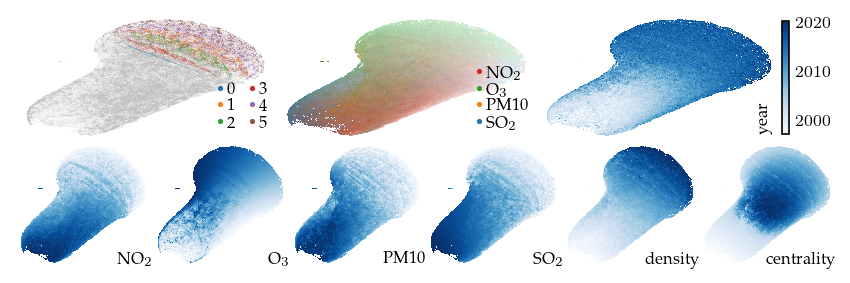

In [13]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "default")
plt.show()

Now, lets explore the projection with filters. First, applying a filter on the
measurement year dimension incorporates an additional signal in the embedding.
This filter keeps only the edges between observations measured in the same or
consecutive years. As a result, regions with similar features measured in
different years are pulled apart. The branches (or flares) created by the filter
indicate states that were not present for some of the years.

In [ ]:
p_year = compute_lens(
    df,
    p,
    "year",
    fun=lu.apply_lens,
    values=df.obs["year"],
    resolution=((df.obs["year"].max() - df.obs["year"].min()) + 1),
    repulsion_strengths=[0.001, 0.01, 0.1, 1, 0.2],
)

Apply lens: 0.02s
Compute layout: 1.08s


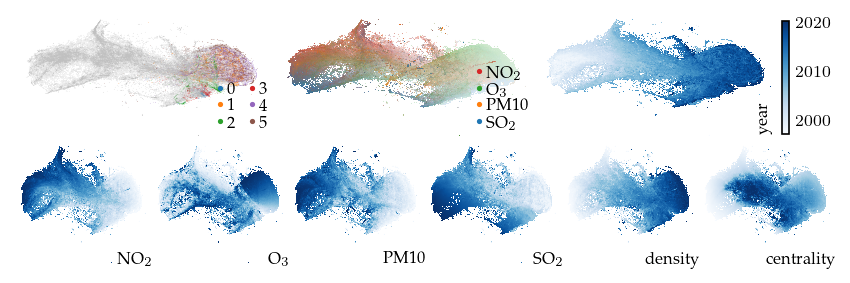

In [15]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "year")
plt.show()

A filter emphasizing the SO2 feature creates an interesting perspective. The
resulting embedding has slices that correspond to the density-based clusters and
reveals discrete SO2 values.

In [ ]:
p_sulfer = compute_lens(
    df,
    p,
    "sulfer",
    fun=lu.apply_local_mask,
    values=df[:, "SO2"].X,
    n_neighbors=20,
    repulsion_strengths=[0.001, 0.01, 0.1, 1, 0.2],
)

Apply lens: 1.06s
Compute layout: 1.42s


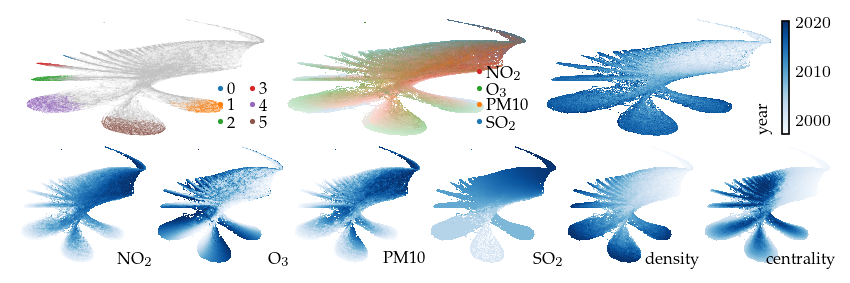

In [17]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "sulfer")
plt.show()

Applying a filter on the density signal is also interesting for exploring
density based clusters. This filter 5 major density maxima and a single density
minimum.

In [ ]:
p_density = compute_lens(
    df,
    p,
    "density",
    fun=lu.apply_local_mask,
    values=df.obs["density"],
    n_neighbors=15,
    repulsion_strengths=[0.001, 0.01, 0.1, 1, 0.2],
)

Apply lens: 0.75s
Compute layout: 1.21s


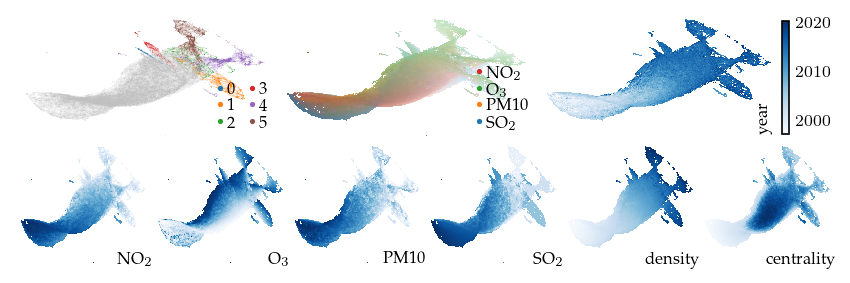

In [21]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "density")
plt.show()

Applying a filter on centrality estimates can also provide interesting
perspectives. Such filters can reveal low-density flares or branches. In this
case, a centrality filter reveals one major centrality maxima (expected) and two
centrality minima, indicating that there are no considerable flares.

In [ ]:
p_centrality = compute_lens(
    df,
    p,
    "centrality",
    fun=lu.apply_local_mask,
    values=df.obs["centrality"],
    n_neighbors=15,
    repulsion_strengths=[0.001, 0.01, 0.1, 1, 0.2],
)

Apply lens: 0.82s
Compute layout: 1.24s


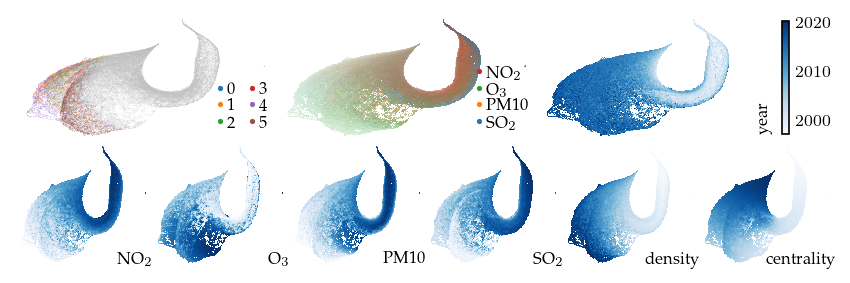

In [23]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "centrality")
plt.show()

Filters can also be used to incorporate features that inherently use different
notions of distance. For example, a filter on GPS coordinates using the
`haversine` distance. This filter separates similar observations by their
measurement location. The resulting embedding appears to have several 'strands'
for early measurements, while more recent measurements remain connected. 

In [ ]:
p_gps = compute_lens(
    df,
    p,
    "gps",
    fun=lu.apply_local_mask,
    values=df.obs[["latitude", "longitude"]],
    metric="haversine",
    n_neighbors=5,
    reset_local_connectivity=True,
    repulsion_strengths=[0.001, 0.01, 0.1, 1, 1, 0.1, 0.1],
)

Apply lens: 1.12s
Compute layout: 0.82s


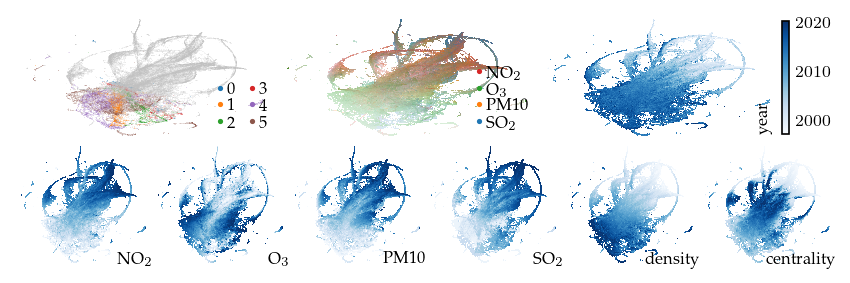

In [25]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "gps")
plt.show()

Finally, emphasizing the Ozon feature with a filter separates the density-based
clusters into multiple branches that we have not yet explained.

In [ ]:
p_ozon = compute_lens(
    df,
    p,
    "ozon",
    fun=lu.apply_local_mask,
    values=df[:, "O3"].X,
    n_neighbors=10,
    reset_local_connectivity=True,
    repulsion_strengths=[0.001, 0.01, 0.1, 1, 0.2],
)

Apply lens: 1.11s
Compute layout: 1.03s


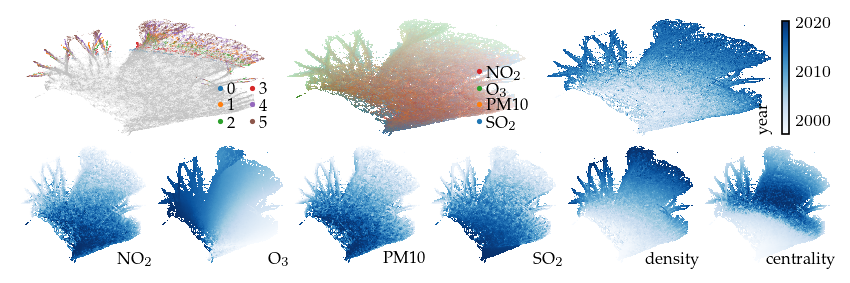

In [41]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "ozon")
plt.show()

## Other exploration strategies:

### Blended mutual nearest neighbor UMAP

Lowering UMAP's `set_op_mix_ratio` can also reveal hidden patterns with a
suitable repulsion strength. This parameter controls how UMAP computes its
simplicial set from the nearest neighbors matrix $N$. UMAP computes a linear
blend between the intersection and union of $N$ and $N^T$. With lower mix ratios
take the result favours the intersection, resulting in strong edges between
*mutual* nearest neighbors.

In [ ]:
p_mutual = compute_projection(
    df,
    "mutual",  # name
    n_neighbors=50,
    set_op_mix_ratio=0.05,
    repulsion_strengths=[0.001, 0.01, 0.1, 1, 1, 1, 0.2],
)

Build UMAP model: 10.06s
Compute layout: 2.80s


Applying this technique to the air quality data set separates the density-maxima
(i.e., clusters) without applying any other filters.

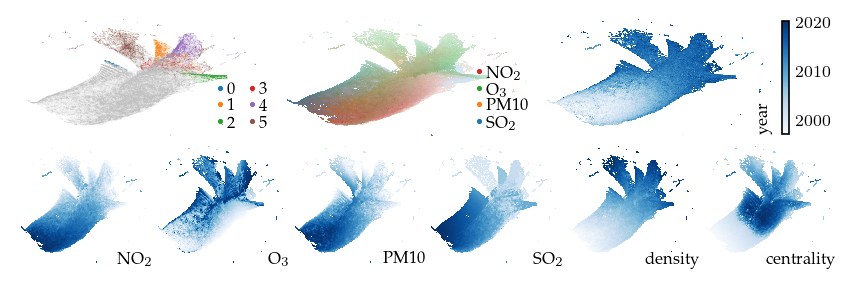

In [43]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "mutual")
plt.show()

### Small multiples

Another alternative is creating multiple UMAP models for different intervals of
a signal. For example, below are six embeddings for different periods of time.

A difference between this approach and the year lens is that the interval
embeddings do not describe how which points are similar between the intervals.
Lining up similar points across the embeddings is possible with the
`AlignedUMAP` class, assuming there is a data point overlap between consecutive
intervals. However, that UMAP variant is not GPU accelerated. Here, we use a
consistent color for the highest feature to detect similarities between
intervals instead.

Another difference is the overall compute cost. Computing multiple smaller UMAP
models was twice as fast as computing the full model and applying a lens over
the year. However, if the full UMAP model is available, then applying the lens
is considerably quicker.

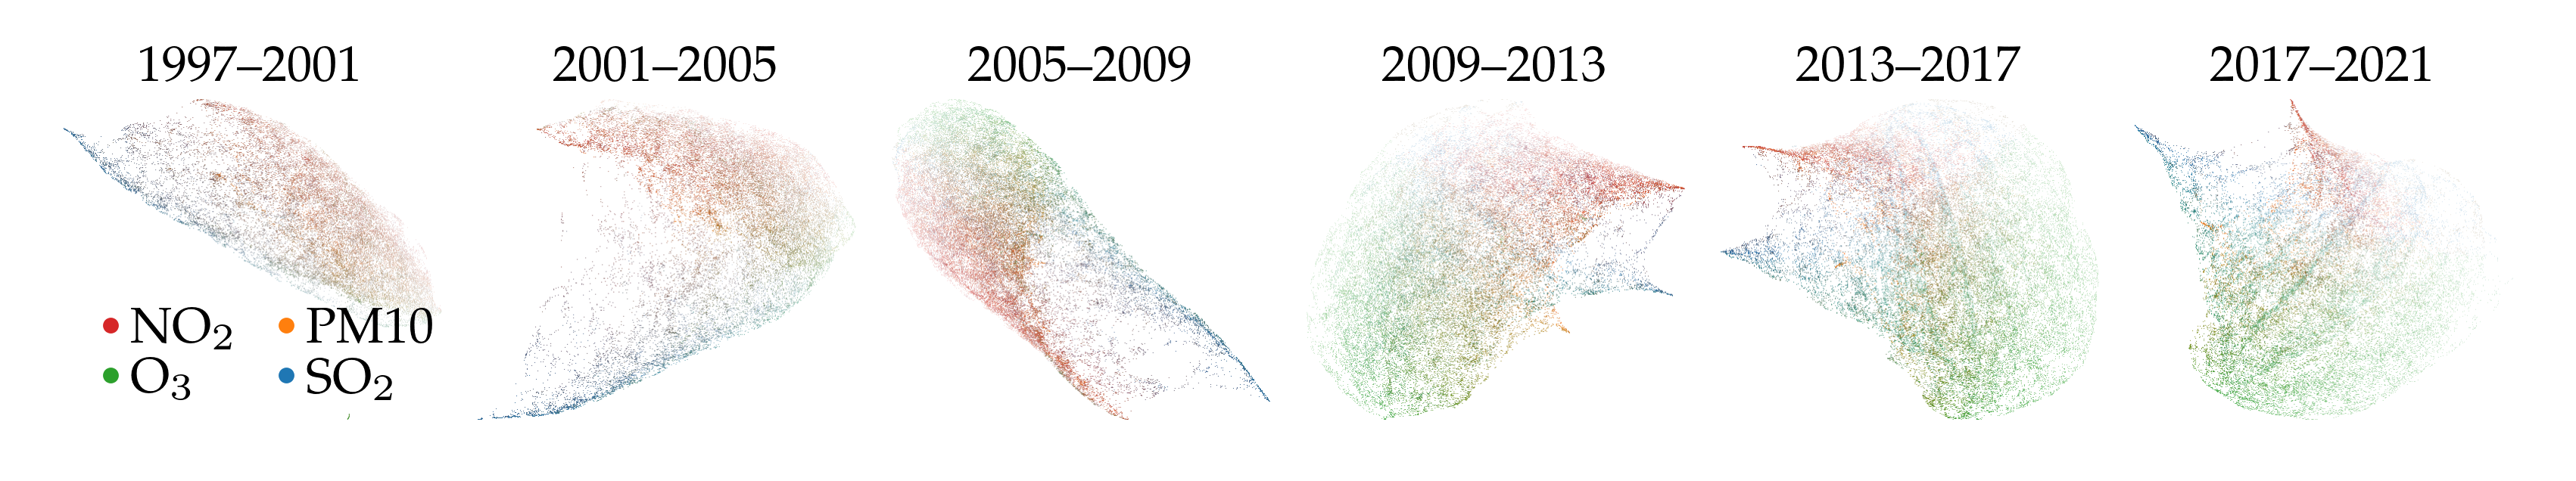

Time to compute binned projections: 8.00s


In [ ]:
bins = np.arange(df.obs["year"].min(), df.obs["year"].max() + 4, 4)

sized_fig(1, 1 / 6, dpi=600)
plt.subplots_adjust(0, 0, 1, 0.85, 0, 0)
timer = 0
for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
    sub_df = df[df.obs["year"].between(lower, upper)].copy()
    start_time = time.perf_counter()
    compute_projection(
        sub_df,
        "binned",
        n_neighbors=25,
        repulsion_strengths=[0.001, 0.01, 0.1, 1, 1, 1, 0.2],
        verbose=False,
    )
    end_time = time.perf_counter()
    timer += end_time - start_time
    plt.subplot(1, 6, i + 1)
    plot_category(
        sub_df,
        color="feature",
        layout="binned",
        baseline=-0.3,
        min_alpha=40,
        legend_cols=int(i == 0) * 2,
    )
    plt.title(f"{lower}--{upper}", fontsize=8, y=0.9)
plt.savefig("figures/air_year_intervals.pdf", pad_inches=0)
plt.show()
print(f"Time to compute binned projections: {timer:.2f}s")

Another small multiple example showing 6 k-means GPS coordinate clusters. The
main difference between these clusters appears to relate to time. Clusters with
only new locations do not have a high SO2 and NO2 tail.

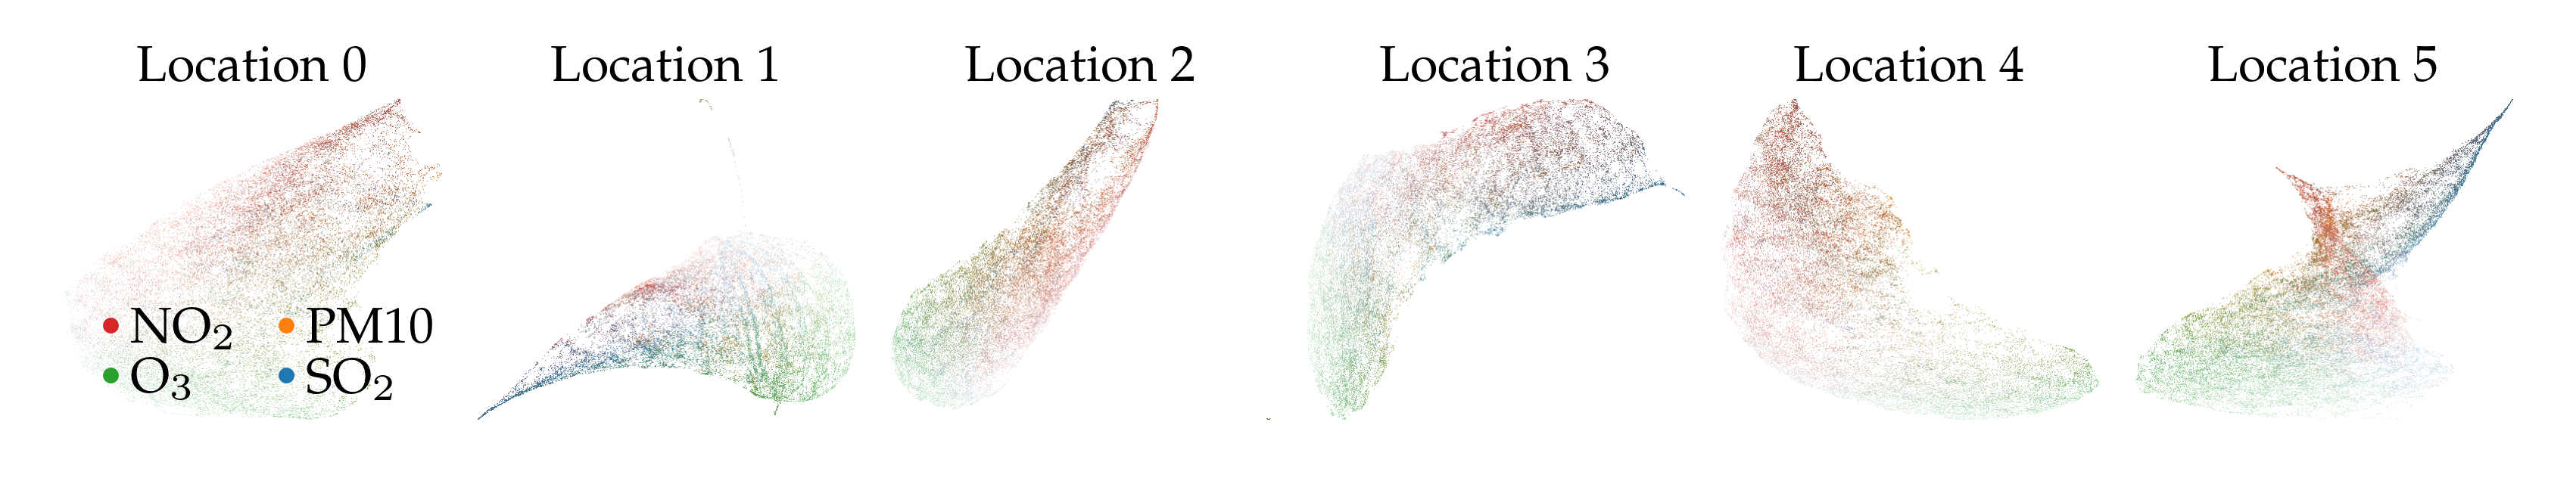

Time to compute binned projections: 6.14s


In [ ]:
from sklearn.cluster import KMeans

gps_clusters = KMeans(n_clusters=6).fit_predict(df.obs[["latitude", "longitude"]])

sized_fig(1, 1 / 6, dpi=600)
plt.subplots_adjust(0, 0, 1, 0.85, 0, 0)
timer = 0
for i in range(6):
    sub_df = df[gps_clusters == i].copy()
    start_time = time.perf_counter()
    compute_projection(
        sub_df,
        "binned",
        n_neighbors=25,
        repulsion_strengths=[0.001, 0.01, 0.1, 1, 1, 1, 0.2],
        verbose=False,
    )
    end_time = time.perf_counter()
    timer += end_time - start_time
    plt.subplot(1, 6, i + 1)
    plot_category(
        sub_df,
        color="feature",
        layout="binned",
        baseline=-0.3,
        min_alpha=40,
        legend_cols=int(i == 0) * 2,
    )
    plt.title(f"Location {i}", fontsize=8, y=0.9)
plt.savefig("figures/air_gps_intervals.pdf", pad_inches=0)
plt.show()
print(f"Time to compute binned projections: {timer:.2f}s")

### Weighted distances



Another alternative is emphasizing or including particular features in the input
data.


For example, emphasizing the SO2 feature before computing UMAP provides similar
embedding as the SO2 local mask. However, tuning the feature strength requires
re-computing the full UMAP model, taking +/- 10 seconds, while the applying the
year lens takes less than 2 seconds.

In [47]:
df.layers["extra_sulfer"] = df.X.copy()
df[:, "SO2"].layers["extra_sulfer"] *= 2

p_sulfer_dist = compute_projection(
    df,
    "extra_sulfer",
    n_neighbors=50,
    input=df.layers["extra_sulfer"],
)

Build UMAP model: 10.79s
Compute layout: 2.61s


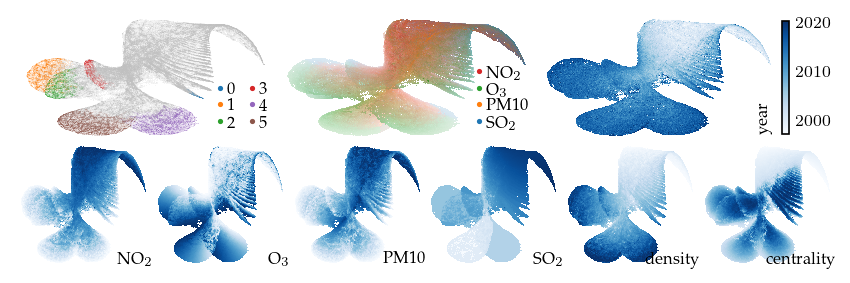

In [48]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "extra_sulfer")
plt.show()

The same does not hold for emphasizing the Ozon feature, which produces a
markedly different embedding when emphasized in the input.

In [50]:
df.layers["extra_ozon"] = df.X.copy()
df[:, "O3"].layers["extra_ozon"] *= 2

p_ozon_dist = compute_projection(
    df, "extra_ozon", n_neighbors=50, input=df.layers["extra_ozon"]
)

Build UMAP model: 10.85s
Compute layout: 2.53s


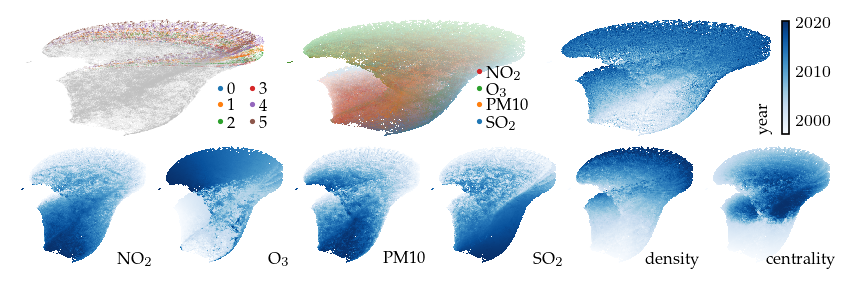

In [51]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "extra_ozon")
plt.show()

Similarly, adding the year dimension as feature in the distance computation does
not produce an embedding similar to the year lens. Instead, observations in the
same year move closer together, overruling the structure that was there without
the year feature in the distance.

In [54]:
X_with_year = np.column_stack(
    (df.X, 1.5 * RobustScaler().fit_transform(df.obs.year.values[:, None]))
)

p_year_dist = compute_projection(df, "extra_year", n_neighbors=50, input=X_with_year)

Build UMAP model: 10.15s
Compute layout: 2.68s


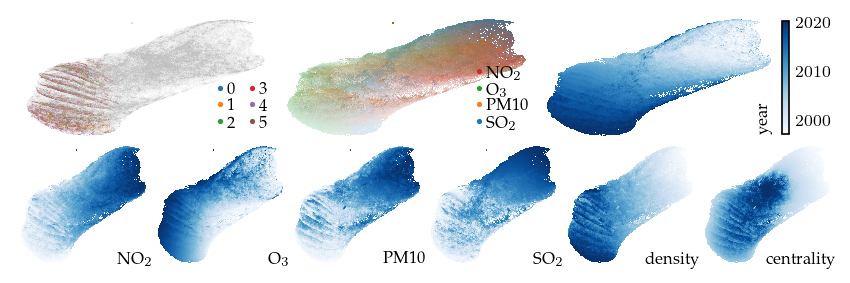

In [55]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "extra_year")
plt.show()

Adding the GPS coordinates as feature in the raw data appears to replicate the
original structure for +/- 8 overall locations. The resulting embedding does not
resemble the GPS local mask.

In [56]:
X_with_gps = np.column_stack(
    (df.X, 0.5 * RobustScaler().fit_transform(df.obs[["latitude", "longitude"]].values))
)

p_gps_dist = compute_projection(df, "extra_gps", n_neighbors=50, input=X_with_gps)

Build UMAP model: 11.61s
Compute layout: 2.76s


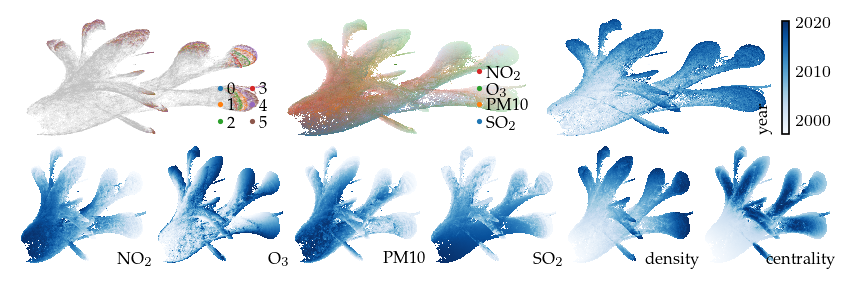

In [57]:
sized_fig(1, 0.618 / 3 + 0.618 / 6)
plot_overview(df, "extra_gps")
plt.show()

## Save data

In [58]:
# Export the data.
df.write_h5ad("data/generated/new_air_quality.h5ad")

## Paper figures

This section exports figures used in the paper based on the saved data.

In [2]:
from anndata import read_h5ad

df = read_h5ad("./data/generated/new_air_quality.h5ad")

In [ ]:
# Correct for colorbar space
base_frac, bar_frac = subplot_fractions(3, 1, 0.18)
base_aspect = 0.618
bar_aspect = base_frac * base_aspect / bar_frac

Edges

In [59]:
lines = []
for layout in df.obsm.keys():
    sized_fig(0.33, dpi=600)
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
    lines.append(plot_edges(df, layout, cnorm="eq_hist", min_alpha=0))
    plt.savefig(f"figures/air_edges_{layout}.pdf", pad_inches=0)
    plt.close()

Small multiples

In [67]:
lines = []
for layout in df.obsm.keys():
    if layout.startswith("extra") or layout in ["default", "mutual", "gps"]:
        continue
    sized_fig(0.33, dpi=600)
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
    feature_name_map = dict(ozon="O3", sulfer="SO2")
    feature_name = feature_name_map.get(layout, layout)
    feature = (
        df[:, feature_name].X.T[0]
        if feature_name in df.var_names
        else df.obs[feature_name]
    )
    _, binned = lu.apply_lens(
        UMAP(transform_mode='graph', n_neighbors=50).fit(df.X),
        feature,
        resolution=4,
        ret_bins=True,
        discretization="balanced",
        skip_embedding=True,
    )

    timer = 0
    for i in range(4):
        sub_df = df[binned == i].copy()
        plt.subplot(2, 2, i + 1)
        plt.axis("off")
        if sub_df.n_obs > 25:
            start_time = time.perf_counter()
            compute_projection(
                sub_df,
                "binned",
                n_neighbors=25,
                repulsion_strengths=[0.001, 0.01, 0.1, 1, 1, 1, 0.2],
                verbose=False,
            )
            end_time = time.perf_counter()
            timer += end_time - start_time
            plot_edges(sub_df, "binned", cnorm="eq_hist", min_alpha=0)
            plt.text(
                0,
                1,
                f"{i+1}",
                fontsize=8,
                transform=plt.gca().transAxes,
                va="top",
                ha="left",
            )

    plt.savefig(f"figures/air_multiples_{layout}.pdf", pad_inches=0)
    plt.close()
    print(f"Time to compute small multiples for {layout}: {timer:.2f}s")
    print(f"\t{[feature[binned == i].min() for i in range(4)]}")

Time to compute small multiples for year: 7.16s
	[1997, 2005, 2010, 2015]
Time to compute small multiples for sulfer: 6.83s
	[array(-0.5), array(-0.25), array(0.), array(0.75)]
Time to compute small multiples for density: 7.06s
	[0.039807308465242386, 0.721881628036499, 0.816473126411438, 0.8799872398376465]
Time to compute small multiples for centrality: 7.25s
	[0.021297976533068728, 0.3457999366019527, 0.3961981957639639, 0.4434422300125528]
Time to compute small multiples for ozon: 7.28s
	[array(-1.74193548), array(-0.5483871), array(0.), array(0.4516129)]


In [ ]:
from sklearn.cluster import KMeans

sized_fig(0.33, dpi=600)
plt.subplots_adjust(0, 0, 1, 1, 0, 0)

timer = 0
gps_clusters = KMeans(n_clusters=4).fit_predict(df.obs[["latitude", "longitude"]])
for i in range(4):
    sub_df = df[gps_clusters == i].copy()
    plt.subplot(2, 2, i + 1)
    plt.axis("off")
    if sub_df.n_obs > 0:
        start_time = time.perf_counter()
        compute_projection(
            sub_df,
            "binned",
            n_neighbors=25,
            repulsion_strengths=[0.001, 0.01, 0.1, 1, 1, 1, 0.2],
            verbose=False,
        )
        end_time = time.perf_counter()
        timer += end_time - start_time
        plot_edges(sub_df, "binned", cnorm="eq_hist", min_alpha=0)
        plt.text(
            0,
            1,
            f"{i+1}",
            fontsize=8,
            transform=plt.gca().transAxes,
            va="top",
            ha="left",
        )

plt.savefig(f"figures/air_multiples_gps.pdf", pad_inches=0)
plt.close()
print(f"Time to compute small multiples for gps: {timer:.2f}s")

Time to compute small multiples for gps: 6.59s


Years

In [11]:
lines = []
blues = highpassColors("Blues", 0.2)
for layout in df.obsm.keys():
    sized_fig(bar_frac, bar_aspect, dpi=600)
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
    plot_points(df, layout, color="year", colorbar=True, cmap=blues)
    plt.savefig(f"figures/air_year_{layout}.pdf", pad_inches=0)
    plt.close()

Highest feature (like Silva et al.)

In [6]:
lines = []
for layout in df.obsm.keys():
    sized_fig(0.33, dpi=600)
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
    plot_category(df, layout, "feature", baseline=-0.3, legend_cols=4)
    plt.savefig(f"figures/air_highest_feature_{layout}.pdf", pad_inches=0)
    plt.close()

Lowest feature (like Silva et al.)

In [8]:
lines = []
for layout in df.obsm.keys():
    sized_fig(0.33, dpi=600)
    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
    plot_category(
        df, layout, "feature", baseline=-0.3, operation=lambda x: -x, legend_cols=4
    )
    plt.savefig(f"figures/air_lowest_feature_{layout}.pdf", pad_inches=0)
    plt.close()

Filter feature

In [ ]:
sized_fig(0.33, dpi=600)
plt.subplots_adjust(0, 0, 1, 1, 0, 0)
plot_points(df, "sulfer", "SO2", label=False, colorbar=False)
plt.savefig(f"figures/air_filter_sulfer.pdf", pad_inches=0)
plt.close()

sized_fig(0.33, dpi=600)
plt.subplots_adjust(0, 0, 1, 1, 0, 0)
plot_points(df, "density", "density", label=False, colorbar=False)
plt.savefig(f"figures/air_filter_density.pdf", pad_inches=0)
plt.close()

sized_fig(0.33, dpi=600)
plt.subplots_adjust(0, 0, 1, 1, 0, 0)
for i, period in enumerate(df.uns["colors"]["period"].keys()):
    plt.subplot(2, 2, i + 1)
    df.uns["colors"]["period"] = {
        k: to_hex("silver") if k != period else to_hex(blues(i / 3))
        for k in df.uns["colors"]["period"].keys()
    }
    plot_category(
        df,
        "year",
        "period",
        extent=(-15, 11, -10, 11),
        legend_cols=0,
        baseline=0,
        min_alpha=0,
    )
    plt.text(
        1,
        1,
        period.replace("-", "--"),
        fontsize=8,
        transform=plt.gca().transAxes,
        va="top",
        ha="right",
    )

plt.savefig(f"figures/air_filter_period.pdf", pad_inches=0)
plt.close()

In [12]:
sized_fig(0.33, dpi=600)
plt.subplots_adjust(0, 0, 1, 1, 0, 0)
plot_points(df, "default", "SO2", label=False, colorbar=False, cmap=blues)
plt.savefig(f"figures/air_filter_base_sulfer.pdf", pad_inches=0)
plt.close()

sized_fig(0.33, dpi=600)
plt.subplots_adjust(0, 0, 1, 1, 0, 0)
plot_points(df, "default", "density", label=False, colorbar=False, cmap=blues)
plt.savefig(f"figures/air_filter_base_density.pdf", pad_inches=0)
plt.close()

sized_fig(0.33, dpi=600)
plt.subplots_adjust(0, 0, 1, 1, 0, 0)
plot_points(df, "default", "year", label=False, colorbar=False, cmap=blues)
plt.savefig(f"figures/air_filter_base_year.pdf", pad_inches=0)
plt.close()